# Optimizing shim size for low aspect ratio dipole 
Inspired by: Majernik, N., et al. "Optimization of low aspect ratio, iron dominated dipole magnets." Physical Review Accelerators and Beams 22.3 (2019): 032401.

To run the optimization, in a terminal run: `rsopt optimize configuration optimize_shim.yml`
Requires rsopt being installed (https://github.com/radiasoft/rsopt)

In [1]:
%matplotlib widget

In [24]:
import dipole as dipole_module
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from jupyter_rs_radia import radia_viewer

# Baseline Configuration - No Shim
Before looking at the optimization we will plot the baseline dipole and demonstrate parameterization of the semi-circular shim piece.
Due to symmetry we only specify the 1st quadrant of the dipole.

In [3]:
baseline = pole_dimensions = {
    'pole_width': 1.0,
    'pole_separation': 1.5,
    'pole_height': 1.5,
    'top_height': 1.5,
    'gap_height': 0.75,
    'leg_width': 1.5
}

In [4]:
baseline_points = np.array(dipole_module._create_point_table(**baseline))

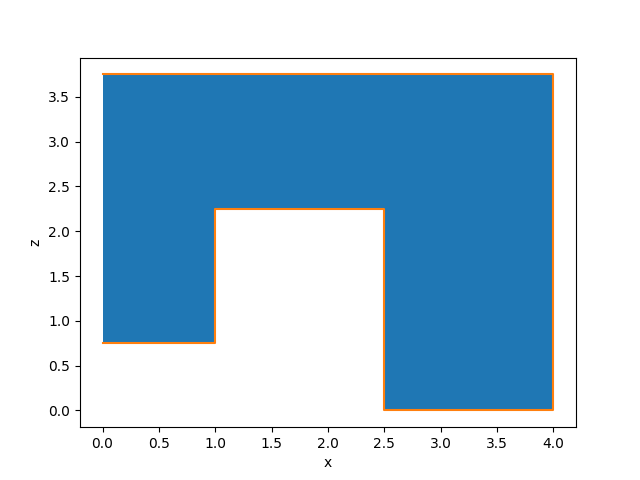

In [5]:
plt.figure()
plt.plot(baseline_points[:, 0], baseline_points[:, 1], c='C1')
plt.fill(baseline_points[:, 0], baseline_points[:, 1])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

# Example with Shim
Apply a shim, formed from a point table. 

In [6]:
SHIM_RADIUS = 0.1
print("Ratio of shim radius to gap", SHIM_RADIUS / baseline['gap_height'])

Ratio of shim radius to gap 0.13333333333333333


In [7]:
def make_shim_point_table(x_center, y_center, radius, count):
    theta = np.linspace(0, -np.pi, count)
    x, y = radius * np.cos(theta) + x_center, radius * np.sin(theta) + y_center
    
    return np.array([x, y]).T.tolist()
    

In [8]:
def make_dipole_table_with_shim(radius, dipole_dict):
    x_center = pole_dimensions['pole_width'] - radius
    shim_table = make_shim_point_table(x_center, pole_dimensions['gap_height'], radius, 25)
    shim_table.append([0., pole_dimensions['gap_height']])
    table = dipole_module._create_point_table(**dipole_dict, pole_face_array=shim_table)
    return table

In [9]:
shim_points = np.array(make_dipole_table_with_shim(SHIM_RADIUS, baseline))

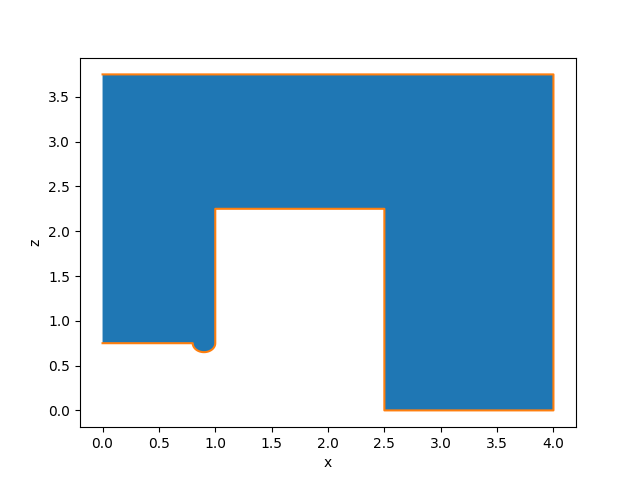

In [10]:
plt.figure()
plt.plot(shim_points[:, 0], shim_points[:, 1], c='C1')
plt.fill(shim_points[:, 0], shim_points[:, 1])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

# Radia Dipole Model
Show the full Radia model of the dipole, including the coils, in 3D

In [11]:
DIPOLE_X_CENTER = 0.00
DIPOLE_X_LENGTH = 25.0
DIPOLE_CURRENT = 2000.

def make_dipole_with_shim(radius, dipole_dict, triangle_min_angle, triangle_max_size):
    if radius is not None:
        x_center = dipole_dict['pole_width'] - radius
        shim_table = make_shim_point_table(x_center, pole_dimensions['gap_height'], radius, 25)
    else:
        shim_table = [[dipole_dict['pole_width'], dipole_dict['gap_height']]]
    shim_table.append([0., dipole_dict['gap_height']])
    dipole = dipole_module.make_dipole(dipole_dict, DIPOLE_X_CENTER, DIPOLE_X_LENGTH,
                                       trimesh_mode=1,
                                       triangle_min_size=triangle_min_angle, triangle_max_size=triangle_max_size,
                                       current=DIPOLE_CURRENT, 
                                       pole_face_array=shim_table)
    return dipole

In [12]:
dipole = make_dipole_with_shim(SHIM_RADIUS, baseline,
                              triangle_min_angle=20.,
                              triangle_max_size=0.5)

In [13]:
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Hbend', dipole)

In [14]:
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

# Model Measurements
*Run jthe solve in the 3D viewer above before proceeding*

## Plotting Start Case

In [15]:
import radia as rad

In [16]:
def field_in_plane(y_min, y_max, obj, steps=25):
    int_field = []
    yc = np.linspace(y_min, y_max, steps)
    for y in yc:
        v = rad.FldInt(obj, 'inf', 'ibz', [-150, y, 0.], [150, y, 0.])
        int_field.append(v)
    return np.array([yc, int_field])

In [17]:
res_0 = field_in_plane(-1., 1., dipole, steps=125)

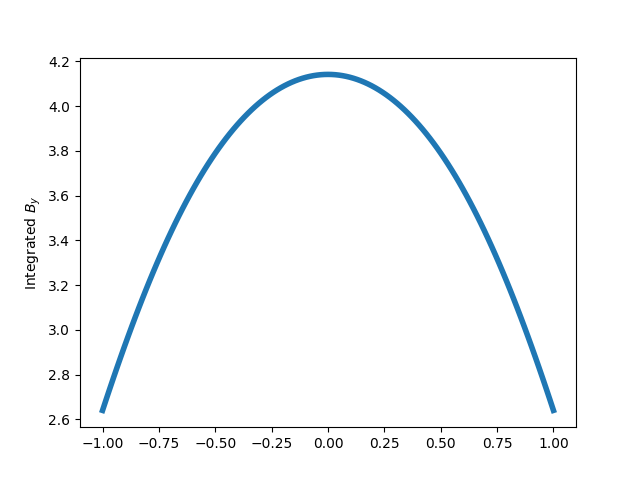

In [18]:
plt.figure()
plt.plot(*res_0, linewidth=4)
plt.ylabel(r'Integrated $ B_y$')
plt.show()

# Formulate Objective Function
## ($\sum_i B^{\rm{int}}_z(x_i) - B^{\rm{int}}_z(0)$,   $B^{\rm{int}}_z(x_i) - B^{\rm{int}}_z(0)$)

In [20]:
int_bz0 = rad.FldInt(dipole, 'inf', 'ibz', [-150, 0., 0.], [150, 0., 0.])
int_bz0

4.142181949111733

Objective function particular to algorithm used

In [21]:
def obj_f(_):
    field_prof = field_in_plane(-3.5, 3.5, dipole, steps=125)
    int_bz0 = rad.FldInt(dipole, 'inf', 'ibz', [-150, 0., 0.], [150, 0., 0.])
    res = field_prof[1, :] - int_bz0
    return np.sum(res**2),  res

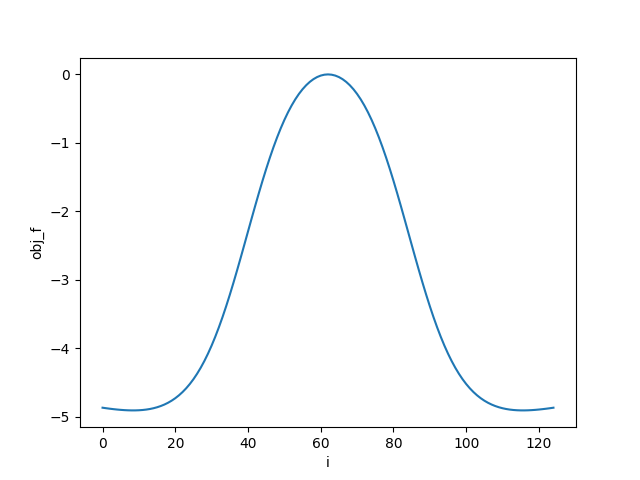

In [22]:
plt.figure()
s, r = obj_f(0)
plt.plot(r)
plt.xlabel('i')
plt.ylabel('obj_f')
plt.show()

# Evaluate Optimization
*Will need to have run rsopt before executing the following cells*

In [36]:
path = pathlib.Path('optimize_shim_size')

In [37]:
H = np.load([p for p in path.glob('*.npy')][0])

In [38]:
Hc = H[H['sim_id'] >= 0]

## Progress of the optimization

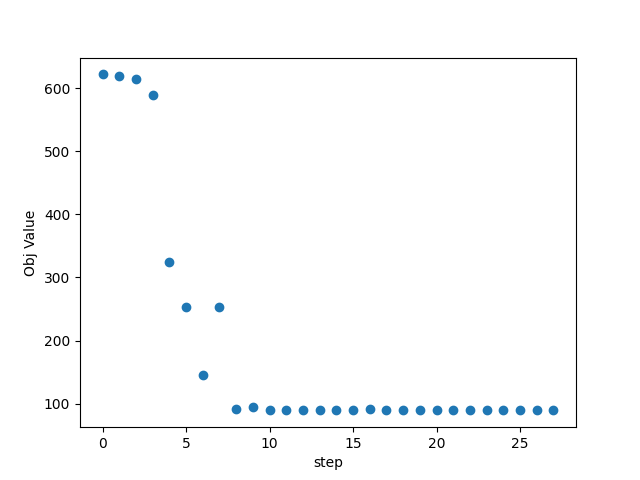

In [39]:
plt.figure()
plt.scatter(Hc['sim_id'], Hc['f'])
plt.xlabel('step')
plt.ylabel('Obj Value')
plt.show()

In [40]:
print("Optimum shim radius", Hc['x'][np.argmin(Hc['f'])][0])

Optimum shim radius 0.20144283158253945


In [41]:
print(f'{"Radius":^20}', f'{"Obj f":^20}')
for x, f in zip(Hc['x'], Hc['f']):
    print("{:<20}".format(x[0]), f)

       Radius               Obj f        
0.01                 621.794511880839
0.015                619.6119175736326
0.019999999999999997 613.8729638503057
0.039999999999999994 589.7311390768448
0.11999999999999998  323.7778281065514
0.25                 253.21716482812667
0.16882885794204416  145.67414810425527
0.25                 253.21716482812667
0.1975176782047572   90.9007182839026
0.19226944602523294  94.11159089756276
0.20178129620769547  89.76018021985519
0.20112296124158113  89.68461058594912
0.20187296124158113  90.2212049622632
0.20037296124158113  90.0957382553082
0.20144271756181467  89.55458343167422
0.20176211286457424  89.70379631876384
0.2014826491813482   91.73723631846183
0.20144338727656153  89.9423852026252
0.20144231868135207  90.00955606682628
0.20144296756181468  89.56773135930068
0.20144283158253945  89.32476861926234
0.20144237549964036  89.89048657441582
0.20144305962398898  90.03911718698978
0.20144271756181467  89.55458343167422
0.20144287134558023  89.

## Show the starting and final field profiles

In [42]:
Hc['x'][np.argmin(Hc['f'])]
sim_min = Hc['sim_id'][np.argmin(Hc['f'])]

In [53]:
# Load profiles
start = np.load(path / 'worker2/sim0/field_in_plane.npy')
mid = np.load(path /  'worker2/sim7/field_in_plane.npy')
end = np.load(path / f'worker2/sim{sim_min}/field_in_plane.npy')

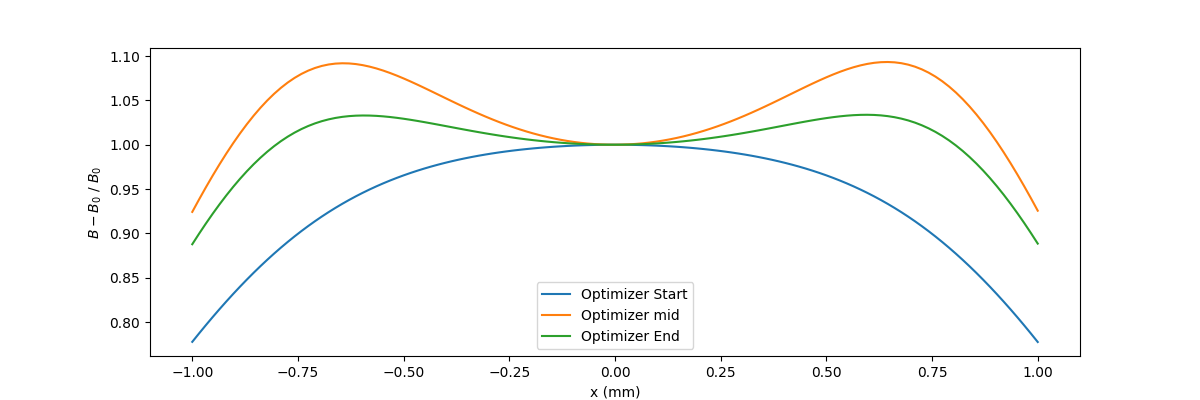

In [54]:
plt.figure(figsize=(12, 4))
# plt.plot(reference[0,:], reference[1,:] / reference[1,:][reference[1,:].size // 2], label='No Shim')
plt.plot(start[0,:], start[1,:] / start[1,:][start[1,:].size // 2], label='Optimizer Start')
plt.plot(mid[0,:], mid[1,:] / mid[1,:][mid[1,:].size // 2], label='Optimizer mid')
plt.plot(end[0,:], end[1,:] / end[1,:][end[1,:].size // 2], label='Optimizer End')

plt.xlabel('x (mm)')
plt.ylabel(r'$B - B_0$ / $B_0$')
plt.legend()
plt.show()